In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
from pymc.math import invlogit

%load_ext lab_black
%load_ext watermark

# eBay purchase example

This example shows some of the effects different priors can have on your results.

From [unit 4: eBay.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit4/eBay.odc).

Associated lecture video: Unit 4 Lesson 17: eBay Purchase Example


## Problem statement

You've decided to purchase a new Orbital Shaking Incubator for your research lab on eBay.

Two sellers are offering this item for the same price, both with free shipping. Seller A has 95% positive feedback from 100 responders, while seller B has 100% positive feedback from 3 responders. We assume that all 103 responders are different, unrelated customers, to avoid dependent responses.

From which seller should you order?

That depends on your priors!

```{note}
I changed labels 1 and 2 in the model to A and B to align with the problem definition.
```

In [2]:
# data
pos_A = 95
tot_A = 100

tot_B = 3
pos_B = 3

In [3]:
# lots of problems in PyMC 4, probably need to redo later
with pm.Model() as m:
    # priors
    priors_A = (
        pm.Beta("uniform_A", alpha=1, beta=1),
        pm.Beta("jeffrey_A", alpha=0.5, beta=0.5),
        pm.Beta("informative_A", alpha=30, beta=2),
        pm.Deterministic(
            "zellner_A", invlogit(pm.Uniform("ign_A", lower=-1000, upper=1000))
        ),
        pm.LogitNormal("norm_A", mu=3, sigma=1),
    )

    priors_B = (
        pm.Beta("uniform_B", alpha=1, beta=1),
        pm.Beta("jeffrey_B", alpha=0.5, beta=0.5),
        pm.Beta("informative_B", alpha=2.9, beta=0.1),
        pm.Deterministic(
            "zellner_B", invlogit(pm.Uniform("ign_B", lower=-1000, upper=1000))
        ),
        pm.LogitNormal("norm_B", mu=3, sigma=1),
    )

    # likelihoods
    for A, B in zip(priors_A, priors_B):
        prior_type = A.name.strip("_A")

        pm.Binomial("y_" + A.name, n=tot_A, p=A, observed=pos_A)
        pm.Binomial("y_" + B.name, n=tot_B, p=B, observed=pos_B)

        pm.Deterministic("diff_" + prior_type, A - B)

    # start sampling
    trace = pm.sample(4000, tune=2000, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [uniform_A, jeffrey_A, informative_A, ign_A, norm_A, uniform_B, jeffrey_B, informative_B, ign_B, norm_B]


Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 25 seconds.
There were 2801 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3381 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2751 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2955 divergences after tuning. Increase `target_accept` or reparameterize.


PyMC is deeply unhappy with the professor's formulation but the results are the same as BUGS, so I'm going to leave well enough alone.

In [4]:
az.summary(trace, var_names=["~ign_A", "~ign_B"], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
uniform_A,0.941,0.023,0.895,0.981,0.000,0.000,4657.0,5037.0,1.0
jeffrey_A,0.945,0.023,0.901,0.986,0.000,0.000,3612.0,3883.0,1.0
informative_A,0.947,0.020,0.906,0.981,0.000,0.000,3818.0,4235.0,1.0
norm_A,0.950,0.020,0.907,0.983,0.000,0.000,3309.0,4086.0,1.0
uniform_B,0.800,0.162,0.478,1.000,0.003,0.002,2756.0,2383.0,1.0
jeffrey_B,0.879,0.144,0.571,1.000,0.002,0.002,1677.0,905.0,1.0
informative_B,0.983,0.049,0.900,1.000,0.000,0.000,2513.0,1819.0,1.0
norm_B,0.943,0.052,0.838,0.998,0.001,0.001,3644.0,5296.0,1.0
zellner_A,0.950,0.022,0.907,0.987,0.000,0.000,4403.0,4240.0,1.0
zellner_B,1.000,0.001,1.000,1.000,0.000,0.000,5172.0,16000.0,1.0


The results are pretty close to the professor's BUGS results:

|           | mean     | sd       | MC_error | val2.5pc | median    | val97.5pc |
|-----------|----------|----------|----------|----------|-----------|-----------|
| diffps[1] | 0.1417   | 0.1649   | 4.93E-04 | -0.06535 | 0.1018    | 0.5448    |
| diffps[2] | 0.06921  | 0.1485   | 4.63E-04 | -0.08247 | 0.01423   | 0.4774    |
| diffps[3] | -0.03623 | 0.05252  | 1.70E-04 | -0.09355 | -0.04494  | 0.1144    |
| diffps[4] | -0.05004 | 0.02177  | 7.02E-05 | -0.1003  | -0.04712  | -0.0164   |
| diffps[5] | 0.00658  | 0.05593  | 1.73E-04 | -0.06808 | -0.005543 | 0.1526    |
| p1[1]     | 0.9412   | 0.02319  | 7.40E-05 | 0.8882   | 0.9442    | 0.9778    |
| p1[2]     | 0.9456   | 0.02235  | 7.13E-05 | 0.8944   | 0.9485    | 0.9808    |
| p1[3]     | 0.9471   | 0.01937  | 6.09E-05 | 0.9031   | 0.9493    | 0.9782    |
| p1[4]     | 0.9499   | 0.02169  | 7.04E-05 | 0.8997   | 0.9529    | 0.9836    |
| p1[5]     | 0.9498   | 0.01973  | 5.96E-05 | 0.9043   | 0.9525    | 0.9804    |
| p2[1]     | 0.7995   | 0.1632   | 4.89E-04 | 0.3982   | 0.8402    | 0.9938    |
| p2[2]     | 0.8764   | 0.1468   | 4.56E-04 | 0.4694   | 0.9336    | 0.9999    |
| p2[3]     | 0.9833   | 0.04892  | 1.58E-04 | 0.8344   | 0.9999    | 1         |
| p2[4]     | 1        | 0.001891 | 5.84E-06 | 1        | 1         | 1         |
|  p2[5]    | 0.9432   | 0.05234  | 1.66E-04 | 0.7986   | 0.9592    | 0.9935    |

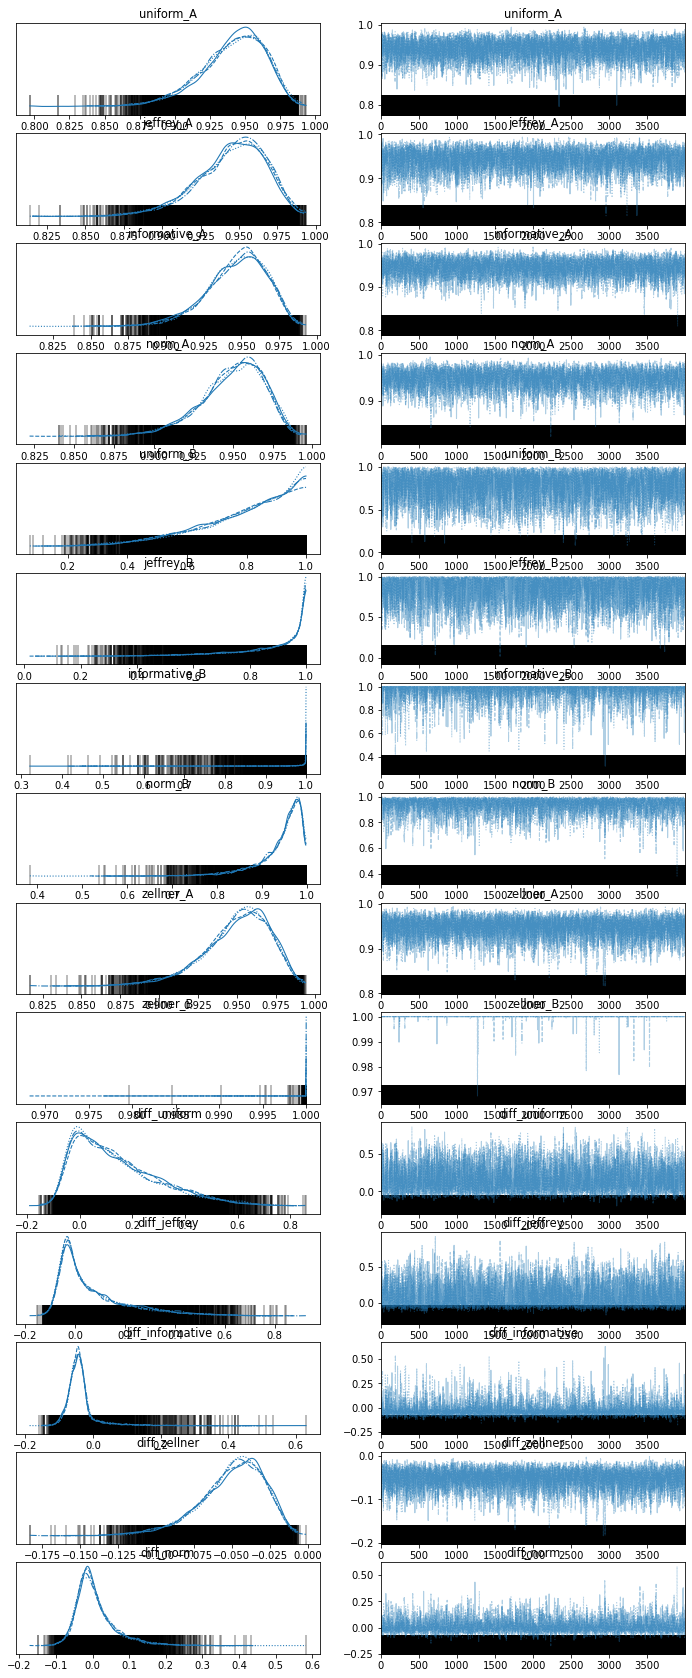

In [5]:
az.plot_trace(trace, var_names=["~ign_A", "~ign_B"])
plt.show()

I'd like to expand on this answer in the future, leaving it for now!

In [6]:
%watermark -n -u -v -iv -p aesara,aeppl

Python implementation: CPython
Python version       : 3.10.4
IPython version      : 8.4.0

matplotlib: 3.5.2
pymc      : 4.0.1
arviz     : 0.12.1
numpy     : 1.22.4

